# The Barn

Prepares data for The Barn signature events page

In [1]:
import os

from events import (
    load_event_data, filter_public_events, filter_by_project, prepare, save_files, count_wards, filter_public_events, filter_community_events, filter_school_events
)

import ticket_helpers

Set an output directory

In [2]:
OUT_DIR = '../../../../docs/metrics/events/the-barn/_data/events'

Read in event data and filter by **The Barn**

In [3]:
data = (
  load_event_data()
    .pipe(filter_by_project, '05 - The Barn')
  )

Run the processing and save the files

In [4]:
data = data.pipe(prepare).pipe(save_files, OUT_DIR)

data

,actual_audience_size_number_of_participants_in_person,actual_audience_size_number_of_participants_online,airtable_id,end_date,event_name,event_type,event_unique_identifier,number_of_booked_participants,postcode_(from_venue),project_name,project_type,season,start_date,status,ticket_tailor_id,ward_(from_venue),ward_name,ward_code,audience_size
216,8.0,NaN,958,NaN,WOWsers Workshop 1,['CLE - Youth Voice session'],05 - The Barn: WOWsers Workshop 1,7.0,['LS10 1NE'],05 - The Barn,Produce (Signature),['Season 1 - Awakening'],2023-02-18,01 - Greenlit,NaN,['Hunslet and Riverside'],Hunslet and Riverside,E05011399,8.0
269,31.0,NaN,201,2023-03-02,Barn Raiser Bootcamp 1,['CLE - Skills and Talent session'],05 - The Barn: Barn Raiser Bootcamp 1,NaN,['LS2 7QT'],05 - The Barn,Produce (Signature),"['Season 1 - Awakening', 'Season 2 - Playing']",2023-03-02,01 - Greenlit,NaN,['Little London and Woodhouse'],Little London and Woodhouse,E05011403,31.0
271,8.0,NaN,959,2023-03-02,WOWsers Workshop 2,['CLE - Youth Voice session'],05 - The Barn: WOWsers Workshop 2,8.0,['LS10 1NE'],05 - The Barn,Produce (Signature),['Season 1 - Awakening'],2023-03-02,01 - Greenlit,NaN,['Hunslet and Riverside'],Hunslet and Riverside,E05011399,8.0
302,8.0,NaN,963,2023-03-11,WOWsers Workshop 3,['CLE - Youth Voice session'],05 - The Barn: WOWsers Workshop 3,8.0,NaN,05 - The Barn,Produce (Signature),['Season 1 - Awakening'],2023-03-11,01 - Greenlit,NaN,NaN,<NA>,NaN,8.0
304,17.0,NaN,1442,2023-03-13,Dream Builders Workshop - Women Speak,['CLE - Community Engagement session'],05 - The Barn: Dream Builders Workshop - Women...,NaN,['LS11 7HL'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-03-13,01 - Greenlit,NaN,['Beeston and Holbeck'],Beeston and Holbeck,E05012647,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,120.0,NaN,1161,2023-05-16,Natalie Haynes,['Public Event - Performance'],05 - The Barn: Natalie Haynes,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-16,01 - Greenlit,ev_2064393,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,120.0
526,128.0,NaN,351,2023-05-18,The Space Digital Interactive Playspace,"['Public Event - Digital Experience', 'CLE - C...",05 - The Barn: The Space Digital Interactive P...,7.0,NaN,05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-16,01 - Greenlit,NaN,NaN,<NA>,NaN,128.0
527,4.0,0.0,1623,2023-05-18,The Space Digital Interactive Playspace (schoo...,"['Public Event - Digital Experience', 'CLE - C...",05 - The Barn: The Space Digital Interactive P...,7.0,NaN,05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-16,01 - Greenlit,NaN,NaN,<NA>,NaN,4.0
528,45.0,NaN,350,2023-05-18,UKREiif,"['Commercial', 'Public Event - Large Scale Out...",05 - The Barn: UKREiif,NaN,['LS10 1PZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-16,01 - Greenlit,NaN,['Hunslet and Riverside'],Hunslet and Riverside,E05011399,45.0


Filter by public events

In [5]:
PUBLIC_EVENTS_DIR = OUT_DIR+'/public'
os.makedirs(PUBLIC_EVENTS_DIR, exist_ok=True)


public_data = data.pipe(filter_public_events).pipe(save_files, PUBLIC_EVENTS_DIR)
public_data



,actual_audience_size_number_of_participants_in_person,actual_audience_size_number_of_participants_online,airtable_id,end_date,event_name,event_type,event_unique_identifier,number_of_booked_participants,postcode_(from_venue),project_name,project_type,season,start_date,status,ticket_tailor_id,ward_(from_venue),ward_name,ward_code,audience_size
477,264.0,NaN,346,2023-05-01,Barn Raising,"['Public Event - Performance', 'CLE - Skills a...",05 - The Barn: Barn Raising,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-04-30,01 - Greenlit,NaN,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,264.0
481,260.0,0.0,1506,2023-05-01,Topping Out,['Public Event - Performance'],05 - The Barn: Topping Out,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-01,01 - Greenlit,"ev_2103472, ev_2276667",['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,260.0
494,149.0,NaN,1157,2023-05-09,Bridget Christie - 7pm show,['Public Event - Performance'],05 - The Barn: Bridget Christie - 7pm show,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-09,01 - Greenlit,ev_2063298,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,149.0
495,63.0,NaN,1158,2023-05-09,Bridget Christie - 9pm show,['Public Event - Performance'],05 - The Barn: Bridget Christie - 9pm show,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-09,01 - Greenlit,ev_2063299,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,63.0
510,93.0,NaN,1155,2023-05-11,Shazia Mirza - 7pm show,['Public Event - Performance'],05 - The Barn: Shazia Mirza - 7pm show,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-11,01 - Greenlit,ev_2063305,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,93.0
511,101.0,NaN,1181,2023-05-12,Andi Oliver,['Public Event - Performance'],05 - The Barn: Andi Oliver,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-12,01 - Greenlit,ev_2076173,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,101.0
519,128.0,NaN,1159,2023-05-12,Suhaiymah Manzoor-Khan,['Public Event - Performance'],05 - The Barn: Suhaiymah Manzoor-Khan,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-12,01 - Greenlit,ev_2063323,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,128.0
520,300.0,NaN,1163,2023-05-13,Barn Dance,"['Commercial', 'Public Event - Performance']",05 - The Barn: Barn Dance,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-13,01 - Greenlit,NaN,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,300.0
522,1600.0,NaN,204,2023-05-13,WOW Barn Festival,['Public Event - Performance'],05 - The Barn: WOW Barn Festival,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-13,01 - Greenlit,ev_2058305,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,1600.0
524,4000.0,NaN,1175,2023-05-14,Rob Burrow Leeds Marathon at The WOW Barn,['Public Event - Large Scale Outdoor Event'],05 - The Barn: Rob Burrow Leeds Marathon at Th...,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-14,01 - Greenlit,NaN,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,4000.0


Filter by Community events

In [6]:
COMMUNITY_EVENTS_DIR = OUT_DIR+'/community'
os.makedirs(COMMUNITY_EVENTS_DIR, exist_ok=True)

data.pipe(filter_community_events).pipe(save_files, COMMUNITY_EVENTS_DIR)

,actual_audience_size_number_of_participants_in_person,actual_audience_size_number_of_participants_online,airtable_id,end_date,event_name,event_type,event_unique_identifier,number_of_booked_participants,postcode_(from_venue),project_name,project_type,season,start_date,status,ticket_tailor_id,ward_(from_venue),ward_name,ward_code,audience_size
216,8.0,NaN,958,NaN,WOWsers Workshop 1,['CLE - Youth Voice session'],05 - The Barn: WOWsers Workshop 1,7.0,['LS10 1NE'],05 - The Barn,Produce (Signature),['Season 1 - Awakening'],2023-02-18,01 - Greenlit,NaN,['Hunslet and Riverside'],Hunslet and Riverside,E05011399,8.0
269,31.0,NaN,201,2023-03-02,Barn Raiser Bootcamp 1,['CLE - Skills and Talent session'],05 - The Barn: Barn Raiser Bootcamp 1,NaN,['LS2 7QT'],05 - The Barn,Produce (Signature),"['Season 1 - Awakening', 'Season 2 - Playing']",2023-03-02,01 - Greenlit,NaN,['Little London and Woodhouse'],Little London and Woodhouse,E05011403,31.0
271,8.0,NaN,959,2023-03-02,WOWsers Workshop 2,['CLE - Youth Voice session'],05 - The Barn: WOWsers Workshop 2,8.0,['LS10 1NE'],05 - The Barn,Produce (Signature),['Season 1 - Awakening'],2023-03-02,01 - Greenlit,NaN,['Hunslet and Riverside'],Hunslet and Riverside,E05011399,8.0
302,8.0,NaN,963,2023-03-11,WOWsers Workshop 3,['CLE - Youth Voice session'],05 - The Barn: WOWsers Workshop 3,8.0,NaN,05 - The Barn,Produce (Signature),['Season 1 - Awakening'],2023-03-11,01 - Greenlit,NaN,NaN,<NA>,NaN,8.0
304,17.0,NaN,1442,2023-03-13,Dream Builders Workshop - Women Speak,['CLE - Community Engagement session'],05 - The Barn: Dream Builders Workshop - Women...,NaN,['LS11 7HL'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-03-13,01 - Greenlit,NaN,['Beeston and Holbeck'],Beeston and Holbeck,E05012647,17.0
305,17.0,NaN,1186,NaN,Dream Builders Workshop - Women Speak,['CLE - Community Engagement session'],05 - The Barn: Dream Builders Workshop - Women...,15.0,NaN,05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-03-13,01 - Greenlit,NaN,NaN,<NA>,NaN,17.0
315,36.0,NaN,608,2023-03-18,Barn Raiser Bootcamp 2,['CLE - Skills and Talent session'],05 - The Barn: Barn Raiser Bootcamp 2,NaN,['LS2 7QT'],05 - The Barn,Produce (Signature),"['Season 1 - Awakening', 'Season 2 - Playing']",2023-03-18,01 - Greenlit,NaN,['Little London and Woodhouse'],Little London and Woodhouse,E05011403,36.0
316,3.0,NaN,1165,NaN,WOWsers Workshop 4,['CLE - Youth Voice session'],05 - The Barn: WOWsers Workshop 4,3.0,['LS10 1NE'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-03-18,01 - Greenlit,NaN,['Hunslet and Riverside'],Hunslet and Riverside,E05011399,3.0
319,19.0,NaN,1183,NaN,Dream Builders Workshop - LS14 Trust,['CLE - Community Engagement session'],05 - The Barn: Dream Builders Workshop - LS14 ...,NaN,NaN,05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-03-20,01 - Greenlit,NaN,['Killingbeck and Seacroft'],Killingbeck and Seacroft,E05011400,19.0
320,18.0,NaN,1440,2023-03-20,Dream Builders Workshop - Seacroft Hookers,['CLE - Community Engagement session'],05 - The Barn: Dream Builders Workshop - Seacr...,NaN,NaN,05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-03-20,01 - Greenlit,NaN,['Killingbeck and Seacroft'],Killingbeck and Seacroft,E05011400,18.0


Filter by Schools events

In [7]:
SCHOOLS_EVENTS_DIR = OUT_DIR+'/schools'
os.makedirs(SCHOOLS_EVENTS_DIR, exist_ok=True)


data.pipe(filter_school_events).pipe(save_files, SCHOOLS_EVENTS_DIR)

,actual_audience_size_number_of_participants_in_person,actual_audience_size_number_of_participants_online,airtable_id,end_date,event_name,event_type,event_unique_identifier,number_of_booked_participants,postcode_(from_venue),project_name,project_type,season,start_date,status,ticket_tailor_id,ward_(from_venue),ward_name,ward_code,audience_size
496,60.0,NaN,1434,2023-05-09,School Day: Greenmount Primary,['CLE - Creative Learning session'],05 - The Barn: School Day: Greenmount Primary,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-09,01 - Greenlit,NaN,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,60.0
497,45.0,NaN,1447,2023-05-09,School Day: IQRA Academy Primary,['CLE - Creative Learning session'],05 - The Barn: School Day: IQRA Academy Primary,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-09,01 - Greenlit,NaN,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,45.0
498,30.0,NaN,1433,2023-05-09,School Day: Lane End Primary,['CLE - Creative Learning session'],05 - The Barn: School Day: Lane End Primary,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-09,01 - Greenlit,NaN,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,30.0
499,45.0,NaN,1448,2023-05-09,School Day: Moor Allerton Hall Primary,['CLE - Creative Learning session'],05 - The Barn: School Day: Moor Allerton Hall ...,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-09,01 - Greenlit,NaN,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,45.0
502,90.0,NaN,1439,2023-05-10,School Day: Allerton CE Primary School,['CLE - Creative Learning session'],05 - The Barn: School Day: Allerton CE Primary...,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-10,01 - Greenlit,NaN,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,90.0
503,60.0,NaN,1436,2023-05-10,School Day: Temple Learning Academy,['CLE - Creative Learning session'],05 - The Barn: School Day: Temple Learning Aca...,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-10,01 - Greenlit,NaN,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,60.0
504,34.0,NaN,1435,2023-05-10,School Day: Whinmoor St Paul's C of E,['CLE - Creative Learning session'],05 - The Barn: School Day: Whinmoor St Paul's ...,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-10,01 - Greenlit,NaN,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,34.0
506,30.0,NaN,1450,2023-05-11,School Day: Leeds City Academy,['CLE - Creative Learning session'],05 - The Barn: School Day: Leeds City Academy,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-11,01 - Greenlit,NaN,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,30.0
507,30.0,NaN,1430,2023-05-11,School Day: Royds Hall,['CLE - Creative Learning session'],05 - The Barn: School Day: Royds Hall,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-11,01 - Greenlit,NaN,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,30.0
508,50.0,NaN,1446,2023-05-11,School Day: The Halifax Academy,['CLE - Creative Learning session'],05 - The Barn: School Day: The Halifax Academy,NaN,['LS6 2UZ'],05 - The Barn,Produce (Signature),['Season 2 - Playing'],2023-05-11,01 - Greenlit,NaN,['Headingley and Hyde Park'],Headingley and Hyde Park,E05011397,50.0


Print a list of events which have no ward, or more than one

In [8]:
data[data.pipe(count_wards) != 1][[
    'airtable_id',
    'event_name',
    'start_date',
    'ward_(from_venue)',
]]

,airtable_id,event_name,start_date,ward_(from_venue)
302,963,WOWsers Workshop 3,2023-03-11,NaN
305,1186,Dream Builders Workshop - Women Speak,2023-03-13,NaN
362,1189,Dream Builders Workshop - Verd de Gris,2023-03-31,NaN
457,612,Professionals Online Bootcamp,2023-04-20,NaN
462,1443,Dream Builder's Workshop - Maternal Journal,2023-04-24,NaN
466,1188,Dream Builders Workshop - Millan Centre,2023-04-26,NaN
467,1190,Dream Builders Workshop - Women's Activity Cen...,2023-04-26,NaN
470,1444,Dream Builders Workshop - Mums on a Mission,2023-04-27,NaN
471,1445,Dream Builders Workshop - DASH,2023-04-27,NaN
472,1187,Dream Builders Workshop - Womenzonecc,2023-04-27,NaN


Print a list of events with no audience recorded

In [9]:
data[data.audience_size == 0][[
    'airtable_id', 'event_name', 'start_date', 'audience_size'
]]

,airtable_id,event_name,start_date,audience_size


Plot event types shown

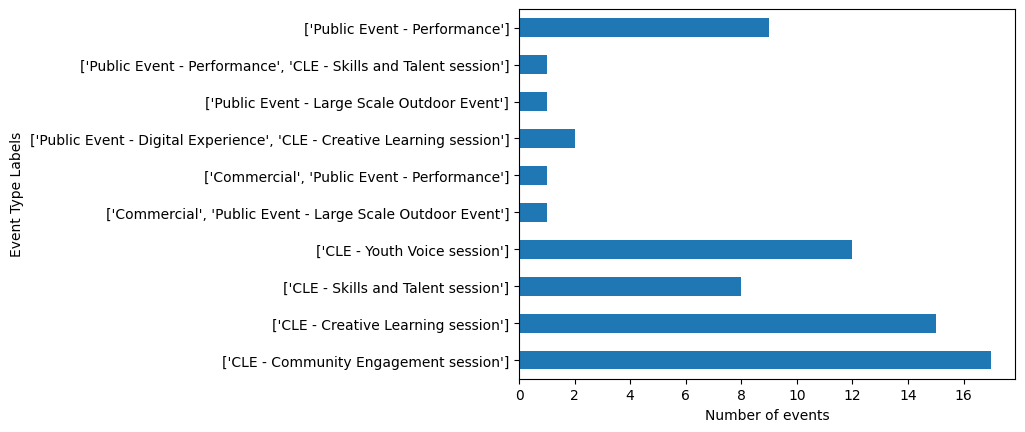

In [10]:
plot = data.groupby('event_type').event_name.count().plot.barh()
plot.xaxis.label.set_text('Number of events')
plot.yaxis.label.set_text('Event Type Labels')

Ticket processing

In [11]:
ticket_sales = data.pipe(filter_public_events).pipe(ticket_helpers.get_tickets_for_event)

By ward

In [12]:
ticket_sales.pipe(ticket_helpers.summarise_by_ward).reset_index().to_csv(
    os.path.join(OUT_DIR, 'tickets_by_ward.csv'), index=False)

By date

In [13]:
(
  ticket_sales
    .pipe(ticket_helpers.summarise_by_date)
    .resample('W-FRI').sum()
    .cumsum().to_csv(os.path.join(OUT_DIR, 'tickets_by_date.csv'))
)